# Structured Optimization


# 1 - Data and Library Loading

In [155]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from sklearn.cluster import KMeans
random.seed(1)

1/ Load and plot the training data. Which model seems to have generated the data? In particular, how many "centroids" can you count?

In [156]:
data_train = np.genfromtxt('train.dat', delimiter=" ", dtype='f8')
data_test = np.genfromtxt('test.dat', delimiter=" ", dtype='f8')
n_point, n_dimension = data_train.shape
n_state = 4

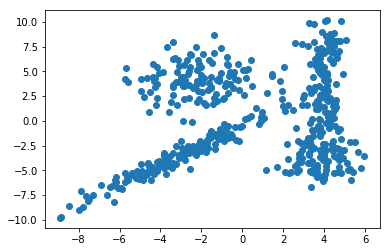

In [157]:
plt.scatter(data_train[:,0], data_train[:,1])
plt.show()

# 2 First approach: k-means algorithm

2/ Use the $k$-means algorithm in order to cluster the data into $K$ classes stored in vector $z\in\{0,1,2,3\}^T$. Return the the vector $\tau \in \{0,1\}^{T \times K}$ such that
$
\tau_{t,k} = 
\begin{cases}
1 & \text{if}\;\;z_t=k\\
0 & \text{otherwise}.
\end{cases}
$

Hint: use the $\texttt{sklearn}$ library.

In [158]:
def kmeans(x, K):
    """
    inputs:
    x : [T,D], T points of dimension D 
    K : integer, number of clusters
    outputs:
    tau [T,k] output, one-hot encoding of the clustering in k classes
    """
    T = x.shape[0]
    kmeans = KMeans(n_clusters=K, random_state=0).fit(x)
    z = kmeans.labels_
    tau = np.zeros((T, K),dtype='f8')
    tau[np.arange(T),z] = 1 #FILL TAU
    return tau

3/ Compute and plot the k-means affectation for $K=4$. <font color=red> What assumption of the $k$-means algorithm is not well-suited to the data?

In [159]:
def plot_affectation(x, cluster_indices):
    """
    cluster_indices [T], array of cluster indices
    """
    colors = ['k', 'r', 'g', 'b']
    markers = [ 'o', 's', '+', 'x']
    for i_state in range(n_state):
        plt.scatter(x[cluster_indices==i_state,0], x[cluster_indices==i_state,1], c=colors[i_state], marker=markers[i_state])

## Answer question 3:
## K-means does hard clustering which mean that each datapoint has to belong to one and only one cluster. With this data it's better to use soft clustering than hard clustering.

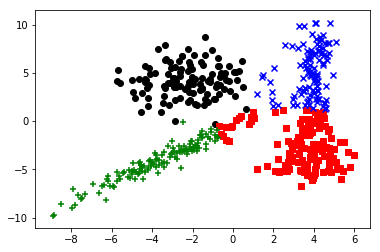

In [160]:
x= data_train
K = 4
tau = kmeans(x,K) #TODO
cluster_indices = np.argmax(tau,axis=1)
plot_affectation(x,cluster_indices)#TODO
plt.show()

# 3 EM-algorithm for the Gaussian Mixture Model

We first model the data by a Gaussian Mixture Model (GMM): the observed data is comprised of $T$ i.i.d random variables $X_t \mapsto \mathbb{R}^{2}$  which follow a mixture of $K$ Gaussians. The choice of the Gaussian component in the mixture is determined by a latent variable $Z_t \mapsto \{0,\cdots,K-1\}$ following a multinomial distribution.
To each entry $t \in [0,\cdots,T-1]$ we associate an observation $x_t$ and a latent variable $z_t$, and denote by $x\in \mathbb{R}^{T \times 2}$ the vector of $T$ observations and $z\in \{0,\cdots,K-1\}^{T}$ a corresponding vector of latent variables.

$$
p(x,z) = \prod_{t=0}^{T-1} p(x_t,z_t) = \prod_{t=0}^{T-1} p(z_t) p(x_t \mid z_t)~.
$$

The latent variables follow each a multinomial distribution parameterized by $\pi \in \mathbb{R}^K$: 
$$
p(z_t=k) = \pi_k~.
$$
The conditional probability $p(x_t \mid z_t=k)$ follows a Gaussian distribution parameterized by the centroid $\mu_k \in \mathbb{R}^{2}$ and covariance  matrix $\Sigma_k \in \mathbb{R}^{ 2 \times 2}$:
$$
p(x_t\mid z_t=k) \sim \frac1{(2\pi)^{D/2} \mid\Sigma_i\mid^{1/2}}
\exp{\left(-\frac12(x_t-\mu_k)^\intercal \Sigma_k^{-1} (x_t-\mu_k)\right)},
$$

5 / Draw the model in plate notation.

6 / Complete the function $\texttt{log_gaussian}(x, mu, Sigma)$ which returns the logarithm of the emission probability of value $x$ by a normal distribution parameterized by $\mu$ and $\Sigma$. Run the test cell to check if your code is correct.

Hint: use `np.linalg.det` and `np.linalg.inv`

In [161]:
def log_gaussian(x, mu, Sigma):
    """
    inputs:
    x : [T,D], input T points of dimension D
    mu : [D,], centroid
    Sigma : [D,D], centroid
    outputs:
    float, log probability of x being generated by the gaussian N(mu, sigma)
    """
    D = x.shape[1]
    vec_diff = x - mu
    A = - (D/2)* np.log(2*np.pi)- (1/2)*np.log(np.linalg.det(Sigma))
    B = (1/2)* np.diag((vec_diff @ np.linalg.inv(Sigma) @ vec_diff.T))
    return A - B #TODO

In [162]:
#the next assert checks the correcteness of the log-gaussian function's code! the assert must pass
mu = np.array([1,1])
Sigma = np.array([[1,0.5],[0.3,2]])
x = np.array([[1,0],[10,1]])
assert((np.abs(log_gaussian(x, mu, Sigma)-np.array([ -2.41574016, -45.92925367]))<1e-8).all())

8 / Complete the function $\texttt{log_all_gaussians}(x, mus, Sigmas)$ which returns $p(x_t \mid z_t=k)$ for all the $k$ Gaussian distributions parameterized by $\mu_k$ and $\Sigma_k$:
$$
[p]_{t,k}=p(x_t \mid z_t=k)
$$

In [163]:
def log_all_gaussians(x, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    [T,K]  probability that each data point x_t was generated by the k-th mixture
    """
    n_state = mus.shape[0]
    log_proba = np.zeros((x.shape[0], n_state),dtype='f8')
    for i_state in range(n_state):
        log_proba[:,i_state] = log_gaussian(x, mus[i_state,:], Sigmas[i_state,:,:]) #TODO
    return log_proba

In [164]:
#another code check
mus = np.array([[1,1],[5,5]])
Sigmas = np.array([[[1,0.5],[0.3,2]],[[2,0.5],[0.9,2]]])
x = np.array([[1,0],[10,1]])
assert((np.abs(log_all_gaussians(x, mus, Sigmas)-np.array([[ -2.41574016, -10.07698467], [-45.92925367, -17.96430861]]))<1e-7).all())

6 / Complete the function $\texttt{M_step_mixture}$ which implements the M-step of an EM algorithm for a GMM model. This function returns the parameters $\hat{\pi},\hat{\mu}, \hat{\Sigma}$ learnt from the expected latent variables $\tau_{t,k}=p(z_t=k \mid x; \theta_\text{current})$.

Reminder:
$$
\hat{\pi}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k}}{T} 
$$
$$
\hat{\mu}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k} x_t}{\sum_{t=0}^{T-1} \tau_{t,k}} 
$$
$$
\hat{\Sigma}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k} (x_t-\hat{\mu_k})(x_t-\hat{\mu_k})^\intercal}{\sum_{t=0}^{T-1} \tau_{t,k}} 
$$

In [165]:
#M-step
def M_step_mixture(x, tau):
    """
    x : [T,D] T input points of dimension D
    tau : [T,K] expected latent variable
    outputs:
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    """
    pi = np.zeros((n_state,),dtype='f8')
    mus = np.zeros((n_state, n_dimension),dtype='f8')
    Sigmas = np.zeros((n_state, n_dimension, n_dimension),dtype='f8')
    tau_sum  = tau.sum(0)
    pi = tau_sum / tau.shape[0] #TODO
    mus = (tau.T @ x)/ tau_sum[:,None] #TODO
#     for k_state in range(n_state):
#         x_diff = np.sqrt(tau[:,k_state])[:, None] * (x - mus[k_state,:][None,:])
#         Sigmas[k_state,:,:] = x_diff.T @ x_diff/ tau_sum[k_state]
    for k_state in range(n_state):
        x_diff = x - mus[k_state,:][None,:]
        Sigmas[k_state,:,:] = ( x_diff.T @ np.diag(tau[:, k_state]) @ x_diff) / tau_sum[k_state] #TODO
    return pi, mus, Sigmas

In [166]:
M_step_mixture(data_train, tau)

(array([0.238, 0.286, 0.258, 0.218]), array([[-2.23856221,  4.16339661],
        [ 3.36449672, -2.65646983],
        [-3.78479953, -4.21639713],
        [ 3.80280826,  5.10467248]]), array([[[ 2.18737545,  0.09978376],
         [ 0.09978376,  2.77892178]],
 
        [[ 2.1193328 , -0.86025175],
         [-0.86025175,  4.19922107]],
 
        [[ 3.83569104,  3.73784217],
         [ 3.73784217,  4.00361041]],
 
        [[ 0.58744018,  0.47741776],
         [ 0.47741776,  6.12683473]]]))

5/ Compute $\pi, (\mu_k, \Sigma_k)_k, $ with the value of $\tau$ obtained with $k$-means. Use the function $\texttt{plot_model}(\tau, mus, Sigmas)$ to represent the iso-density contour of each Gaussians. <font color=red> Why does it make sens to use the $\tau$ from k-means with an M-step to compute the parameters of the Gaussians.

## Answer 5:  It make sens to ude the $\tau$ because, it gives us an approximation of the cluster that each data point belongs to.  So using τ can accelerate the M_step to reach the best values for the parameters of the Gaussians.

In [167]:
def plot_model(x, tau, mus, Sigmas):
    def plot_gaussian(mu, Sigma):
        x, y = np.meshgrid(np.linspace(-10, 10, 100),
                       np.linspace(-10, 10, 100))
        def gauss(x,y): return np.exp(log_gaussian(np.array([x,y])[None,:], mu, Sigma)[0])
        vec_gaussian = np.vectorize(gauss)
        plt.contour(x, y, vec_gaussian(x, y),3)
    plt.clf()
    colors = ['k', 'r', 'g', 'b']
    markers = [ 'o', 's', '+', 'x']
    z = tau.argmax(1)
    for k_state in range(n_state):
        plt.scatter(x[z==k_state,0], x[z==k_state,1], c=colors[k_state], marker=markers[k_state])
        plot_gaussian(mus[k_state,:], Sigmas[k_state,:,:])

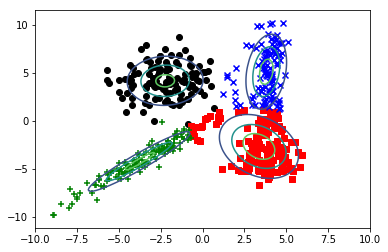

In [168]:
tau=kmeans(data_train, 4)
pi, mus, Sigmas = M_step_mixture(data_train, tau)
plot_model(data_train, tau, mus, Sigmas)

7/ Complete the function $\texttt{logsumexp}(X)=\log(\sum_k(\exp(X_k)))$ which compute the logarithm of sum on the last dimension of elementwise exponentials of an array in a robust way. Try it on the example below, and explain why the naive approach doesn't work.

<font color=red> Justify why this might be necessary when handling normal distributions.

## Answer 7:  This might be necessary when handling normal distributions because, sometimes the values can be very small. With this method, we can avoid any numerical underflows.

In [169]:
def logsumexp(x):
    """
    #compute log(sum(exp(x))) avoiding numerical underflow
    """    
    max_per_line = x.max(-1, keepdims=True)
    return (max_per_line + np.log(np.sum(np.exp(x-max_per_line),-1, keepdims=True))).squeeze()

In [170]:
test_value = np.array([-1000, -2000, -1001])
naive = np.log(np.sum(np.exp(test_value)))
robust = logsumexp(test_value)
print("naive = %f / robust = %f" % (naive, robust))

naive = -inf / robust = -999.686738


/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


7 / Complete the function $\texttt{E_step_mixture}(x, \pi, mus, Sigmas)$ which returns the expected latent values $\tau_{t,k}=p(z_t=k \mid x: \theta_\text{current})$ given by the mixture parameterization $\pi, (\mu_k, \Sigma_k)_k$. <font color='red'> Prove that <font color='black'>:
$$
p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{\sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}
$$

## Demonstration 7:

$$p(z_t=k \mid x; \theta_\text{current}) \text{ is the posterior and according to the Bayes rules: posterior} = \frac{likelihood * prior}{evidende}$$

$$\text{likelihood} = p(x_t \mid z_t=k; \theta_\text{current})$$

$$\text{prior} = p(z_t=k; \theta_\text{current})$$

$$\text{In this case evidence} = p(x_t=k; \theta_\text{current}) =  \sum (\text{likelihood * prior}) \text{ because variables are discrets}$$

$$p(x_t=k; \theta_\text{current}) = \sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})$$

$$p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{p(x_t=k; \theta_\text{current})}$$

So  $$
p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{\sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}
$$

In [171]:
def E_step_mixture(x, pi, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    tau : [T,K] expected latent variable
    """
    num = log_all_gaussians(x, mus, Sigmas) + np.log(pi)
    deno = logsumexp(num)
    log_tau_unnormalized = num - deno[:,None] #np.sum(num,axis=1)[:,None] #TODO
    return np.exp(log_tau_unnormalized) #TODO   

In [172]:
#check that the taus are probabilities
tau = E_step_mixture(data_train, pi, mus, Sigmas)
assert((np.abs(tau.sum(1)-1)<1e-8).all())

8 / Complete the function $\texttt{avg_log_likelihood_mixture}(x)=\log(p(x;\theta_\text{current}))$ which returns the loglikelihood of the vector of observations  $x$ given a Gaussian mixture model parameterized by $\pi, (\mu_k, \Sigma_k)_k$ and normalized by the number of observations.
$$
L(x;\theta_\text{current})=\frac1T \sum_{t=0}^{T-1}\log(p(x_t;\theta_\text{current}))=\frac1T \sum_{t=0}^{T-1}\log\left(\sum_{k=0}^{K-1} p(x_t,z_t=k;\theta_\text{current})\right)
$$

In [173]:
def avg_log_likelihood_mixture(x, pi, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    log-likelihood of x
    """
    log_tau_unnormalized = log_all_gaussians(x, mus, Sigmas) + np.log(pi[None,:])#actually did it for you, nothing to complete
    return (logsumexp(log_tau_unnormalized).sum()) / x.shape[0]

9 / Implement the EM algorithm to learn the mixture parameters $\pi, (\mu_k, \Sigma_k)_k$ from the training set with $K=4$. Initialize with $k$-means. Print the likelihood at each step, what do we observe?

In [174]:
def EM_mixture(x):
    """
    inputs:
    x : [T,D] T input points of dimension D
    outputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    tau : [T,K] expected latent variable
    """
    n_ite = 50
    #first E-step
    tau = kmeans(x, 4)
    #main loop
    for i_ite in range(n_ite):
        #M-step
        pi, mus, Sigmas = M_step_mixture(x, tau) #TODO
        #E-step
        tau = E_step_mixture(x, pi, mus, Sigmas) #TODO
        #likelihood
        print("Mixture iteration %d  - loglikelihood = %1.3f" % (i_ite, avg_log_likelihood_mixture(x,pi,mus, Sigmas))) #TODO))
    return pi, mus, Sigmas, tau

Mixture iteration 0  - loglikelihood = -4.784
Mixture iteration 1  - loglikelihood = -4.712
Mixture iteration 2  - loglikelihood = -4.678
Mixture iteration 3  - loglikelihood = -4.669
Mixture iteration 4  - loglikelihood = -4.665
Mixture iteration 5  - loglikelihood = -4.662
Mixture iteration 6  - loglikelihood = -4.660
Mixture iteration 7  - loglikelihood = -4.659
Mixture iteration 8  - loglikelihood = -4.658
Mixture iteration 9  - loglikelihood = -4.657
Mixture iteration 10  - loglikelihood = -4.657
Mixture iteration 11  - loglikelihood = -4.656
Mixture iteration 12  - loglikelihood = -4.656
Mixture iteration 13  - loglikelihood = -4.656
Mixture iteration 14  - loglikelihood = -4.656
Mixture iteration 15  - loglikelihood = -4.656
Mixture iteration 16  - loglikelihood = -4.656
Mixture iteration 17  - loglikelihood = -4.656
Mixture iteration 18  - loglikelihood = -4.655
Mixture iteration 19  - loglikelihood = -4.655
Mixture iteration 20  - loglikelihood = -4.655
Mixture iteration 21  -

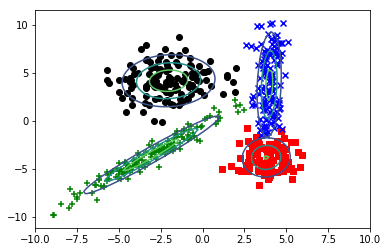

In [175]:
pi, mus, Sigmas, tau = EM_mixture(data_train)
plot_model(data_train, tau, mus, Sigmas)
plt.show()

In [176]:
print("Train loglikelihood = %f" % avg_log_likelihood_mixture(data_train, pi, mus, Sigmas))

Train loglikelihood = -4.655431


9 / Compute the log-likelihood of the test data, visualize the data and comment.

Test loglikelihood = -4.817959


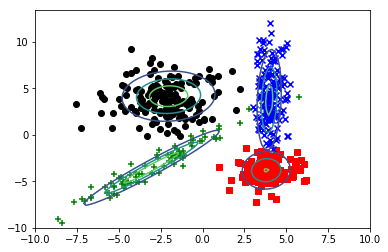

In [177]:
tau = E_step_mixture(data_test, pi, mus, Sigmas)
plot_model(data_test, tau, mus, Sigmas)
print("Test loglikelihood = %f" % avg_log_likelihood_mixture(data_test, pi, mus, Sigmas))

# 4 Hidden Markov Model

10 / We now take into account the temporal structure of the data with a chain-structured hidden Markov model with discrete latent variable $z\in\{0,\cdots,K-1\}^T$:
$$
p(x, z) = p(z_0)\prod_{t=0}^{T-1}  p(x_t \mid z_t)\prod_{t=1}^{T-1} p(z_t \mid z_{t-1}).
$$
We model $p(x_t \mid z_t = k) \sim \mathcal{N}(\mu_k, \Sigma_k)$ like in the previous model, and $p(z_{t+1}=k \mid z_{t}=l)=A_{k,l}$ and finally $p(z_0)$ with a multinomial distribution parameterized by $\pi_0$.

We initialize the Gaussian parameters $\mu_k$ and $\Sigma_k$ with the values $\hat{\mu_k}$ and $\hat{\Sigma_k}$ computed in the mixture model. We initalize $\pi_0$ and $A$ as follows:
$$
\pi_0=\hat{\pi}
$$

$$
[A]_{k,l}=\hat{\pi}_k
$$
Complete the next cell to initialize $A$ and $\pi_0$. <font color = red> How can we interpret this initialization?

## Answer. Interpretation: This intitialization is to improve the classification produced by the previous classifier.

In [178]:
A = np.tile(pi, (n_state, 1))#TODO
pi0 = pi #TODO

10 / Complete the function $\texttt{alpha_beta}(x, pi,mus,Sigmas, A)$ which peforms the marginal inference of the model.

we have the following formulas for the alpha and beta recursions:
$$
\alpha(z_{t}) = p(x_0, \cdots, x_t, z_t)  = p(x_t \mid z_t)\sum_{z_{t-1}=0}^{K-1}\alpha(z_{t-1})\;p(z_{t} \mid z_{t-1})
$$
$$
\beta(z_{t}) = p(x_{t+1}, \cdots, x_T \mid z_t) = \sum_{z_{t+1}=0}^{K-1}\beta(z_{t+1})\;p(z_{t+1}\mid z_{t})\;p(x_{t+1} \mid z_{t+1})
$$

In [179]:
def alpha_beta(x, pi0, mus, Sigmas, A):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    log_proba_emission : [T,K] the probability that each data point x_t was generated by the k-th mixture
    alpha, beta : [T,K] 
    """
    T = x.shape[0]
    log_proba_emission = log_all_gaussians(x, mus, Sigmas)

    #forward pass
    log_alpha = np.zeros((T, n_state), dtype=('f8'))
    log_alpha[0,:] = np.log(pi0) + log_proba_emission[0,:] #TODO
    for t in range(1,T):
        log_alpha[t,] =  log_proba_emission[t,:] + logsumexp(log_alpha[t-1,:]+ np.log(A).T) #TODO
    #backward pass
    log_beta = np.zeros((T, n_state), dtype=('f8'))  
    for t in range(T-2,-1,-1):
        log_beta[t,] = logsumexp(log_beta[t+1,:]  + np.log(A) + log_proba_emission[t+1,:]) #TODO
    return log_proba_emission, log_alpha, log_beta

In [180]:
log_proba_emission, log_alpha, log_beta = alpha_beta(data_train, pi0, mus, Sigmas, A)


11 / Compute the first order marginal probability $\gamma_t= {p(z_t \mid x)}$. Check that the normalization factor is the same for all $t$. Why is that the case? 
Reminder:
$$
\gamma(z_t)=p(z_t \mid x) \propto {\alpha(z_t)\beta(z_t)}
$$

In [181]:
#marginal inference - first order
log_gamma_unnormalized = log_alpha + log_beta #TODO
normalizing_factor = logsumexp(log_gamma_unnormalized) #TODO
log_gamma = log_gamma_unnormalized - normalizing_factor[:,None] #TODO
#check that the normalizing factor is indeed constant
assert((np.abs(normalizing_factor.std())<1e-8).all())

Plot the evolution of the most likely state for each of the first 100 point and comment. <font color = red> How good was our initialization of $A$?

##  The initialization was good because, he allow to get a good alignments in the training phase.

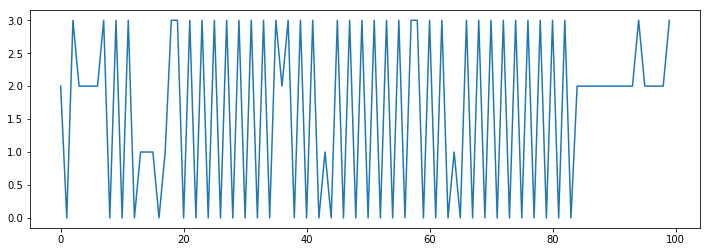

In [182]:
z =log_gamma.argmax(1 )#TODO
figure(figsize=(12,4))
plt.plot(z[0:100])
plt.show()

12 / Compute the pairwise marginals $\xi(z_{t-1},z_t)=p(z_{t-1},z_{t} \mid x; \theta_\text{current})$.

Reminder:
$$
\xi(z_{t-1},z_t)= \frac{\alpha(z_{t-1}) p(x_t \mid z_t; \theta_\text{current}) p(z_t \mid z_{t-1}; \theta_\text{current}) \beta(z_t)}{p(x; \theta_\text{current})}
$$

In [183]:
log_xi = log_alpha[0:-1,:][:,:,None] + log_proba_emission[1:,:][:,None,:] + np.log(A)[None,:,:]+ log_beta[1:,:][:,None,:] - normalizing_factor[0]#TODO
#code check: the pair marginals are indeed probabilities
assert((np.abs(np.exp(log_xi).sum(1).sum(1)-1)<1e-10).all())

13 / Complete the function $\texttt{E_step_HMM}(pi,mus,Sigmas, A)$ which returns the singleton and pairwise marginals as well as the averaged loglikelihood of the observation.

In [184]:
def E_step_HMM(x, pi0, mus,Sigmas, A):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    log_gamma : [T,K] marginals
    log_xi : [T, K, K] patwise marginals
    avg likelihood, float
    """
    log_proba_emission, log_alpha, log_beta = alpha_beta(x, pi0, mus, Sigmas, A) #TODO
    log_gamma_unnormalized = log_alpha + log_beta #TODO
    normalizing_factor = logsumexp(log_gamma_unnormalized)
    log_gamma = log_gamma_unnormalized - normalizing_factor[0]#TODO
    log_xi =  log_alpha[0:-1,:][:,:,None] + log_proba_emission[1:,:][:,None,:] + np.log(A)[None,:,:]+ log_beta[1:,:][:,None,:] - normalizing_factor[0]#TODO
    return log_gamma, log_xi, normalizing_factor[0]/x.shape[0]

14 / Complete the function $\texttt{M_step_HMM}(\gamma, \xi)$ for the HMM model which returns the parameters $\hat{\mu}_k,\hat{\Sigma}_k, \hat{A}$.

$$
[\hat{A}]_{k,l}=\frac{\sum_{t=0}^{T-2}p(z_{t+1}=k,z_{t}=l \mid x; \theta_\text{current})}{\sum_{t=0}^{T-2}\sum_{j=0}^{K-1} p(z_{t+1}=j,z_{t}=l \mid x; \theta_\text{current})}
$$

In [194]:
def M_step_HMM(x, log_gamma, log_xi):
    """
    inputs:
    x: [T,D] T input points of dimension D
    log_gamma [T,K] marginals
    log_xi [T, K, K] patwise marginals
    outputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    """
    pi, mus, Sigmas = M_step_mixture(x, np.exp(log_gamma)) #TODO
    #A = (np.exp(log_xi).sum(0)/ np.exp((log_xi)).sum(0).sum(1)[:, None]).T #TODO
    A = np.exp(log_xi).sum(0)/ np.exp(logsumexp(log_xi.T)).sum(1)
    pi0 = np.exp(log_gamma[0,:])
    return pi0, mus, Sigmas, A

In [195]:
pi0, mus, Sigmas, A =  M_step_HMM(data_train, log_gamma, log_xi)
#A.sum(0)
#a code check that A is indeed a conditional probability
assert(np.all(np.abs(A.sum(0)-1)<1e-10))

16 / Implement the EM algorithm for the HMM model. Initialize the parameters with EM on the Gaussian mixture model.

Mixture iteration 0  - loglikelihood = -4.784
Mixture iteration 1  - loglikelihood = -4.712
Mixture iteration 2  - loglikelihood = -4.678
Mixture iteration 3  - loglikelihood = -4.669
Mixture iteration 4  - loglikelihood = -4.665
Mixture iteration 5  - loglikelihood = -4.662
Mixture iteration 6  - loglikelihood = -4.660
Mixture iteration 7  - loglikelihood = -4.659
Mixture iteration 8  - loglikelihood = -4.658
Mixture iteration 9  - loglikelihood = -4.657
Mixture iteration 10  - loglikelihood = -4.657
Mixture iteration 11  - loglikelihood = -4.656
Mixture iteration 12  - loglikelihood = -4.656
Mixture iteration 13  - loglikelihood = -4.656
Mixture iteration 14  - loglikelihood = -4.656
Mixture iteration 15  - loglikelihood = -4.656
Mixture iteration 16  - loglikelihood = -4.656
Mixture iteration 17  - loglikelihood = -4.656
Mixture iteration 18  - loglikelihood = -4.655
Mixture iteration 19  - loglikelihood = -4.655
Mixture iteration 20  - loglikelihood = -4.655
Mixture iteration 21  -

/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


HMM iteration 47  - likelihood = -3.794
HMM iteration 48  - likelihood = -3.794
HMM iteration 49  - likelihood = -3.794
HMM iteration 50  - likelihood = -3.794
HMM iteration 51  - likelihood = -3.794
HMM iteration 52  - likelihood = -3.794
HMM iteration 53  - likelihood = -3.794
HMM iteration 54  - likelihood = -3.794
HMM iteration 55  - likelihood = -3.794
HMM iteration 56  - likelihood = -3.794
HMM iteration 57  - likelihood = -3.794
HMM iteration 58  - likelihood = -3.794
HMM iteration 59  - likelihood = -3.794
HMM iteration 60  - likelihood = -3.794
HMM iteration 61  - likelihood = -3.794
HMM iteration 62  - likelihood = -3.794
HMM iteration 63  - likelihood = -3.794
HMM iteration 64  - likelihood = -3.794
HMM iteration 65  - likelihood = -3.794
HMM iteration 66  - likelihood = -3.794
HMM iteration 67  - likelihood = -3.794
HMM iteration 68  - likelihood = -3.794
HMM iteration 69  - likelihood = -3.794
HMM iteration 70  - likelihood = -3.794
HMM iteration 71  - likelihood = -3.794


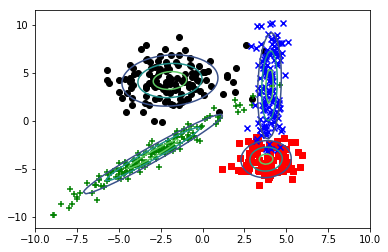

In [196]:
#init with mixture
pi, mus, Sigmas, tau = EM_mixture(data_train)
A = np.tile(pi, (n_state,1))
pi0 = pi
n_ite = 100
#main loop
for i_ite in range(100):    
    #E-step
    log_gamma, log_xi, log_likelihood = E_step_HMM(data_train, pi0, mus, Sigmas, A) #TODO
    print("HMM iteration %d  - likelihood = %1.3f" % (i_ite, log_likelihood))
    #M-step
    pi0, mus, Sigmas, A = M_step_HMM(data_train, log_gamma, log_xi) #TODO
    
plot_model(data_train, np.exp(log_gamma), mus, Sigmas)
plt.show()

18/ Compute the final loglikelihood on the training set and compare it to the one obtained with the mixture model. <font color='red'> Is it a surprising result? Explain why? Make the same comparison on the test set. What conclusion can we draw now?</font>

## Answer 18: The results we get are very surprising, because starting with the last value obtained with GMM, only the four first value of HMM are different. And when we initialize HMM parameters using GMM results, it converge after  just four iterations. This may be due to the fact that we already have an approximation of the different probabilities, for each data point to belong to a cluster. HMM only improve the results we get with GMM.

In [197]:
_log_gamma, _log_xi, log_likelihood_train = E_step_HMM(data_train, pi0, mus, Sigmas, A)
_log_gamma, _log_xi, log_likelihood_test = E_step_HMM(data_test, pi0, mus, Sigmas, A)
print("likelihood train %1.3f  - likelihood test= %1.3f" % (log_likelihood_train, log_likelihood_test))

likelihood train -3.794  - likelihood test= -3.910


/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


19/ <font color = red> If we didn't know in advance the number of states, how would we choose it?

##  Answer 19: If we didn't known in advance the number of state, we would choose using the cross-validation in approach of natural model selectionmodel that the advantage is that it does not impose the unrealistic assumption that the actual distribution of the data belongs to one of the models in competition  as, for instance, AIC(Akaike Information Criterion) and BIC(Bayesian Information Criterion) do.

20 / Implement the Viterbi algorithm for MAP inference / decoding. <font color = red> Explain the difference between marginal and MAP inference.
</font>

Reminder:
the Viterbi algorithm is also called max-product. It computes the sequence of state with the maximum likelihood. It defines $p^\text{map}_{t,i}$ as the probability that the most probable path $0\cdots,t$ end in state $i$. We have the following recursion:
$$
p^\text{map}_{t,i} = p(x_t,z_t=i;\theta_\text{current}) \;\max_j( p^\text{map}_{t-1,j}\; p(z_t=i \mid z_{t-1}=j;\theta_\text{current})
$$
Once $p^\text{map}_{T,i}$ is computed, the last state of the map sequence is $\text{argmax}(p^\text{map}_{T,i})$. To compute the previous state, one simply backtrack through the selected transition computed earlier (keep track of the argmax!).

## Explaination: The difference between marginal and MAP inference is that MAP inference is easier than marginal inference. Marginal inference can be seen as computing and summing all assignments to the model, one of which is the MAP assignment. And in the MAP instead of computing the sum of probability as the marginal do, it choose the  path that maximize the probability of all paths. So MAP gives a better result and it is faster than marginal.

In [198]:
def viterbi(x, pi0, mus, Sigmas, A):
    """
    inputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    map_state T, the MAP affectation
    best_previous_state : the argmax of each max-product
    """
    T = x.shape[0]
    log_proba_emission = log_all_gaussians(x, mus, Sigmas)
    map_state = np.zeros((T,), dtype='uint8') #the map sequence
    best_proba = np.zeros((T,n_state), dtype='f8') #probability of best sequence 1..t being in state i
    best_previous_state = np.zeros((T,n_state), dtype='uint8') #state of the previous observation in the best sequence 1..t
    #init
    #print(log_proba_emission[0,:].T.shape, np.log(pi0).shape)
    best_proba[0,:] = log_proba_emission[0,:].T + np.log(pi0) #TODO
    best_previous_state[0,:] = np.NaN #no previous observation
    #forward pass
    for t in range(1,T):
        proba_previous_state = np.log(A) + best_proba[t-1,:] #TODO
        best_proba[t,] = log_proba_emission[t,:]  + np.max(proba_previous_state) #TODO
        best_previous_state[t,] = np.argmax(proba_previous_state,1)
    #backward pass
    map_state[-1] = best_proba[-1,:].argmax()
    for t in range(T-2,0,-1):#backtrack
        map_state[t] = best_proba[t,:].argmax()#TODO
    return map_state, best_previous_state

/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


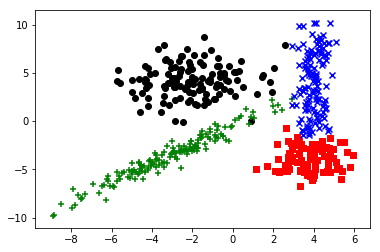

In [199]:
map_state, best_previous_state = viterbi(data_train, pi0, mus,Sigmas, A)
plot_affectation(data_train, map_state)

21 / Launch the visualiziation below representing the backtracking of the Viterbi algorithm. Interpret and comment.

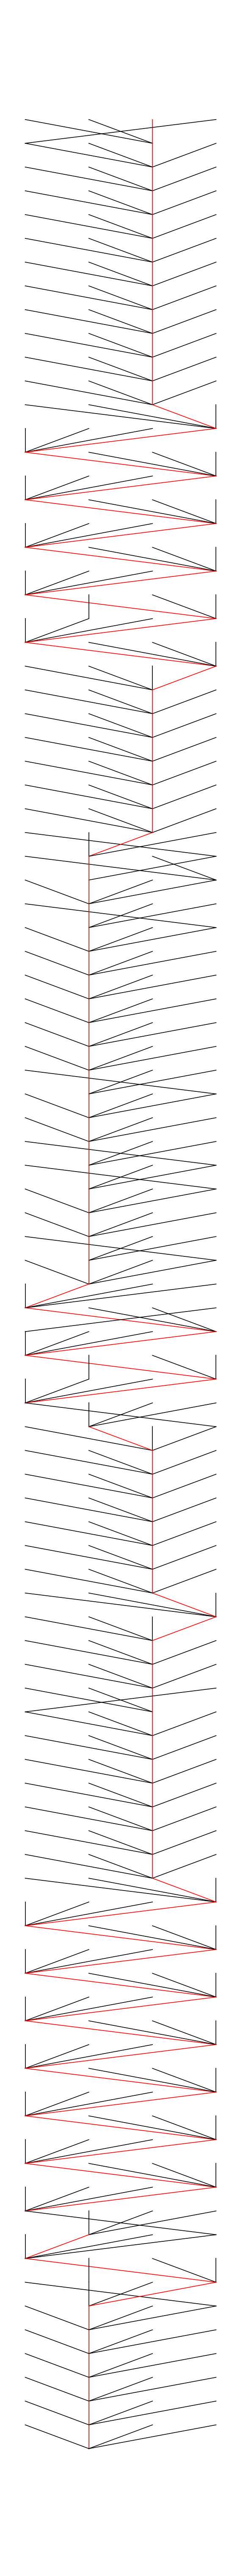

In [200]:
figure(num=None, figsize=(8, 100), dpi=80, facecolor='w', edgecolor='k')
plt.axis('off')
for t in range(n_point-2,n_point-100,-1):
    for i_state in range(n_state):
        if best_previous_state[t,i_state]==map_state[t-1] and i_state==map_state[t]:
            c = 'r'
        else:
            c = 'k'
        plt.plot([i_state, best_previous_state[t,i_state]],[t, t-1], c)
best_previous_state[-10:-1,:] 
plt.show()

## Comment: In this graph, we see that, the red line correspond to the best probability.